<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Plotting-distances" data-toc-modified-id="Plotting-distances-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting distances</a></span></li><li><span><a href="#Testing-for-association-via-Mantel" data-toc-modified-id="Testing-for-association-via-Mantel-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Testing for association via Mantel</a></span></li><li><span><a href="#Testing-for-association-via-Protest" data-toc-modified-id="Testing-for-association-via-Protest-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Testing for association via Protest</a></span></li><li><span><a href="#Most-similar/divergent-via-Procrustes-residuals" data-toc-modified-id="Most-similar/divergent-via-Procrustes-residuals-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Most similar/divergent via Procrustes residuals</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Determine whether bacterial and archaeal alpha diversity significantly correlate

# Var

In [35]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/diversity-qiime2/'

# alpha diversity (calculated via qiime2)
beta_div_arc_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/diversity-qiime2_arc/beta_div_genus.RDS'
beta_div_bac_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/diversity-qiime2_bac/beta_div_genus.RDS'

# 16S-arch phyloseq object; rarefied
physeq_arc_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/physeq_arch_arc-bac_r250.RDS'
# 16S-bac phyloseq object; rarefied
physeq_bac_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/physeq_bac_arc-bac_r5k.RDS'

# params
threads = 8

# Init

In [36]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
library(ape)
library(vegan)
library(doParallel)
library(LeyLabRMisc)

In [37]:
df.dims()
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/arch-bac/diversity-qiime2/ 


# Load

In [38]:
# loading phyloseq object
meta = readRDS(physeq_arc_file) %>%
    phyloseq2df(sample_data) %>%
    dplyr::select(SampleID, class, order, family, genus, scientific_name,
                  diet, habitat, sample_type)
meta 

SampleID,class,order,family,genus,scientific_name,diet,habitat,sample_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F35_Red_Deer,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,terrestrial habitat,feces
F36_Red_Deer,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,terrestrial habitat,feces
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,Mammalia,Perissodactyla,Equidae,Equus,Equus_quagga,herbivore,terrestrial habitat,feces
X67_European_Roe,Mammalia,Artiodactyla,Cervidae,Capreolus,Capreolus_capreolus,herbivore,terrestrial habitat,feces


In [39]:
# archaea beta div
beta_div_arc = readRDS(beta_div_arc_file)
beta_div_arc %>% names

[1] "bray_curtis"        "jaccard"            "unweighted_unifrac"
[4] "weighted_unifrac"

In [40]:
# archaea beta div
beta_div_bac = readRDS(beta_div_bac_file)
beta_div_bac %>% names

[1] "bray_curtis"        "jaccard"            "unweighted_unifrac"
[4] "weighted_unifrac"

# Plotting distances

In [41]:
dist2df = function(D, L){
    m = L[[D]] %>% as.matrix 
    m[upper.tri(m, diag=TRUE)] = NA
    
    m %>% as.data.frame %>%
        mutate(X=rownames(.)) %>%
        gather(Y, value, -X) %>%
        filter(!is.na(value)) %>%
        mutate(Dist = D)
}

df = dist2df('jaccard', beta_div_arc)
df

X,Y,value,Dist
<chr>,<chr>,<dbl>,<chr>
F36_Red_Deer,F35_Red_Deer,0.6,jaccard
F44_Fallow_Deer,F35_Red_Deer,0.5,jaccard
⋮,⋮,⋮,⋮
X67_European_Roe,X405_Nile_Crocodile,1.0000000,jaccard
X67_European_Roe,X431_Quagga,0.8333333,jaccard


# Testing for association via Mantel

In [42]:
D = 'jaccard'
beta_div_arc[[D]] %>% as.matrix %>% dim
beta_div_bac[[D]] %>% as.matrix %>% dim

[1] 140 140

[1] 140 140

In [43]:
Mantel = function(D, L1, L2){
    res = vegan::mantel(L1[[D]], L2[[D]], method='spearman', permutations=999)
    return(c(D, res$statistic, res$signif))
}

doParallel::registerDoParallel(threads)
res = beta_div_arc %>%
    names %>% 
    plyr::llply(Mantel, L1=beta_div_arc, L2=beta_div_bac, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    as.data.frame
colnames(res) = c('measure', 'statistic', 'signif')
res = res %>%
    mutate(signif = signif %>% as.Num,
           padj = p.adjust(signif, method='BH'))
res

measure,statistic,signif,padj
<fct>,<fct>,<dbl>,<dbl>
bray_curtis,-0.0958861827632506,0.997,0.997
jaccard,-0.0139884022237567,0.618,0.997
unweighted_unifrac,-0.0183800578957525,0.701,0.997
weighted_unifrac,-0.0592252661049694,0.906,0.997


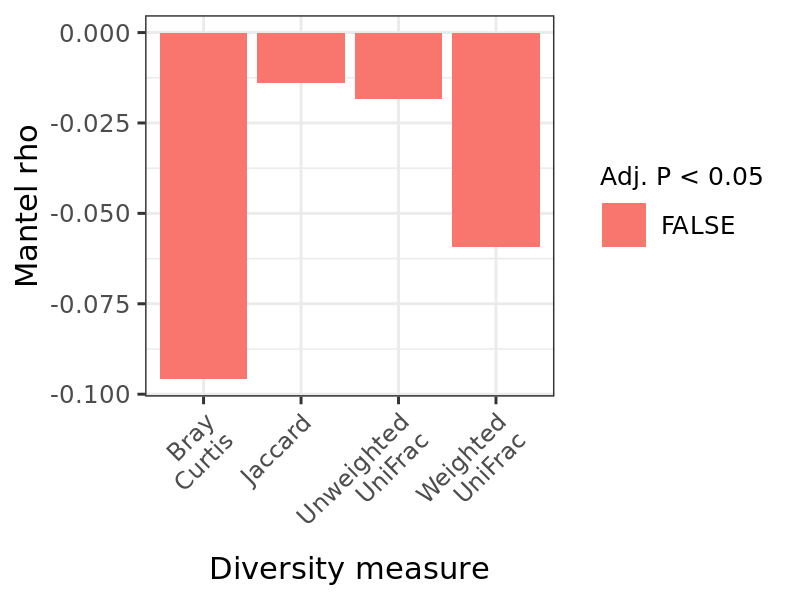

In [52]:
p = res %>%
    mutate(ss = statistic %>% as.Num) %>%
    mutate(measure = case_when(
        measure == 'bray_curtis' ~ 'Bray\nCurtis',
        measure == 'jaccard' ~ 'Jaccard',
        measure == 'weighted_unifrac' ~ 'Weighted\nUniFrac',
        measure == 'unweighted_unifrac' ~ 'Unweighted\nUniFrac')) %>%
    mutate(sig = padj < 0.05) %>%
    ggplot(aes(measure, ss, fill=sig)) +
    geom_bar(stat='identity') +
    scale_fill_discrete('Adj. P < 0.05') +
    labs(x='Diversity measure', y='Mantel rho') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1),
        legend.title = element_text(size=9)
    )

p.dims(4,3)
plot(p)

# Testing for association via Protest

In [11]:
Protest = function(D, L1, L2){
    res = vegan::protest(L1[[D]], L2[[D]], permutations=999)
    return(c(D, res$signif, res$ss))
}

# protest in parallel
doParallel::registerDoParallel(threads)
proc_res = beta_div_arc %>%
    names %>% 
    plyr::llply(Protest, L1=beta_div_arc, L2=beta_div_bac, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    as.data.frame

# formatting
colnames(proc_res) = c('measure', 'signif', 'ss')
proc_res = proc_res %>%
    mutate(signif = signif %>% as.Num,
           padj = p.adjust(signif, method='BH'))
proc_res

measure,signif,ss,padj
<fct>,<dbl>,<fct>,<dbl>
bray_curtis,0.096,0.963875702078336,0.3840000
jaccard,0.373,0.95371709497863,0.4973333
unweighted_unifrac,0.507,0.978025468666036,0.5070000
weighted_unifrac,0.328,0.982823025334387,0.4973333


In [12]:
# formatting
proc_res = proc_res %>%
    mutate(measure = case_when(measure == 'bray_curtis' ~ 'Bray-Curtis',
                               measure == 'jaccard' ~ 'Jaccard',
                               measure == 'unweighted_unifrac' ~ 'Unweighted UniFrac',
                               measure == 'weighted_unifrac' ~ 'Weighted UniFrac'))
proc_res

measure,signif,ss,padj
<chr>,<dbl>,<fct>,<dbl>
Bray-Curtis,0.096,0.963875702078336,0.3840000
Jaccard,0.373,0.95371709497863,0.4973333
Unweighted UniFrac,0.507,0.978025468666036,0.5070000
Weighted UniFrac,0.328,0.982823025334387,0.4973333


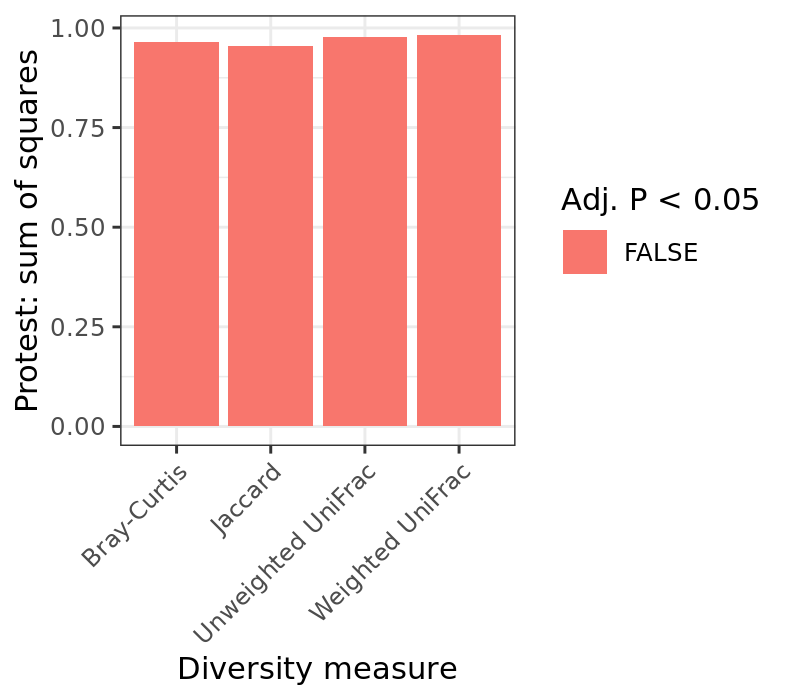

In [20]:
p = proc_res %>%
    mutate(ss = ss %>% as.Num) %>%
    mutate(sig = padj < 0.05) %>%
    ggplot(aes(measure, ss, fill=sig)) +
    geom_bar(stat='identity') +
    scale_fill_discrete('Adj. P < 0.05') +
    labs(x='Diversity measure', y='Protest: sum of squares') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(4,3.5)
plot(p)

# Most similar/divergent via Procrustes residuals

In [14]:
Procrustes = function(D, L1, L2){
    res = vegan::procrustes(L2[[D]], L1[[D]])
    return(res)
}

proc_res1 = beta_div_arc %>%
    names %>% 
    lapply(Procrustes, L1=beta_div_arc, L2=beta_div_bac) 
names(proc_res1) = beta_div_arc %>% names

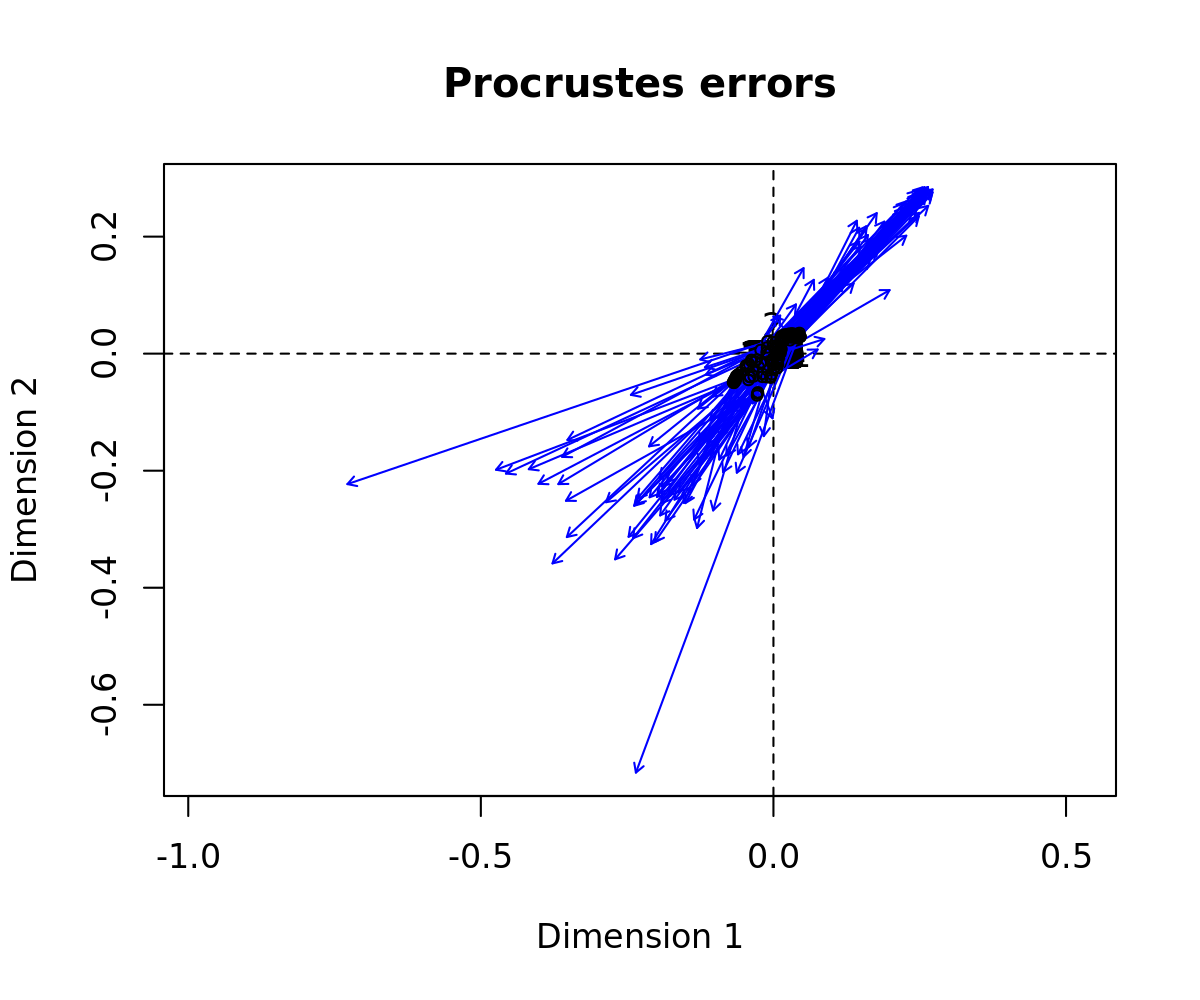

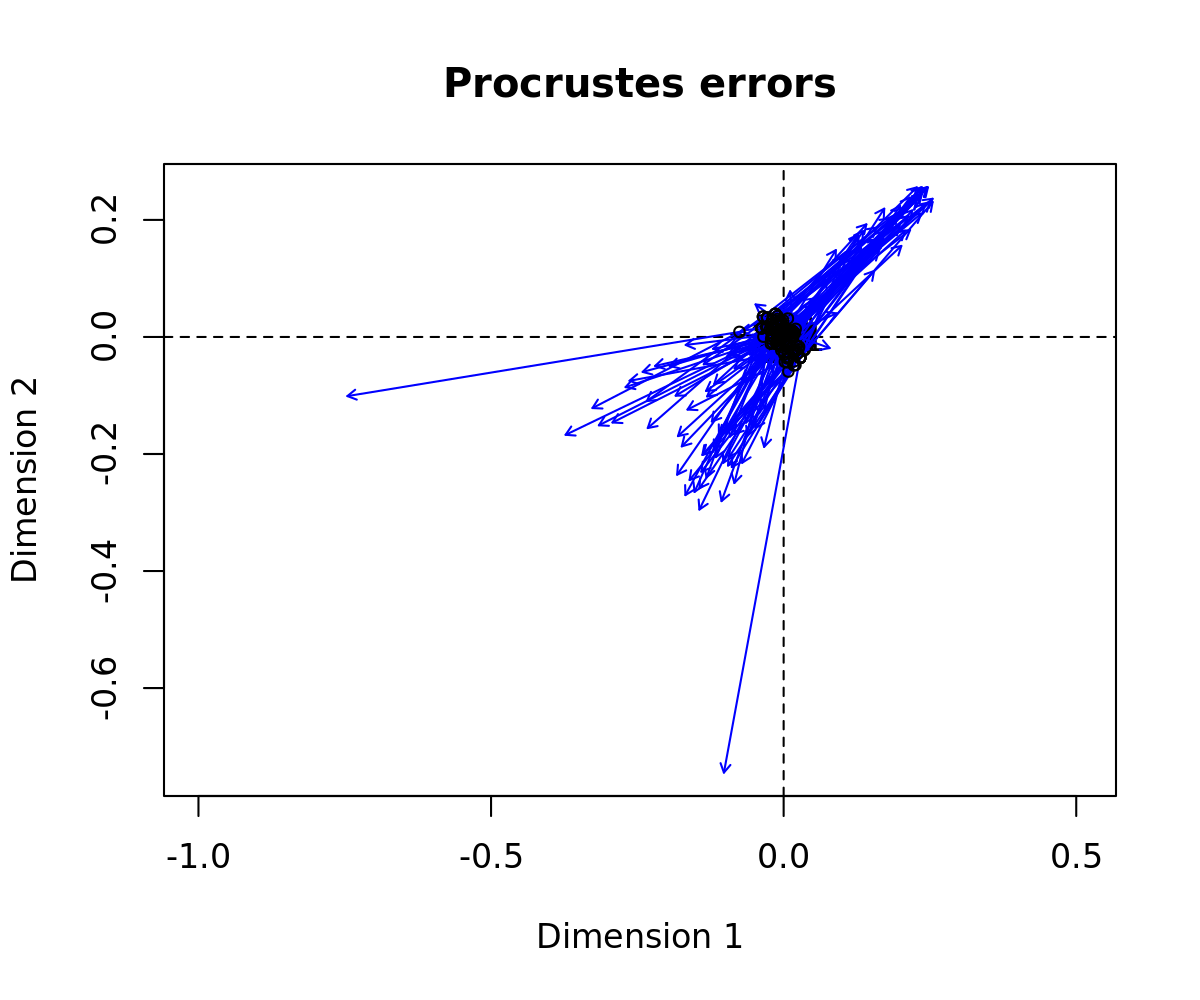

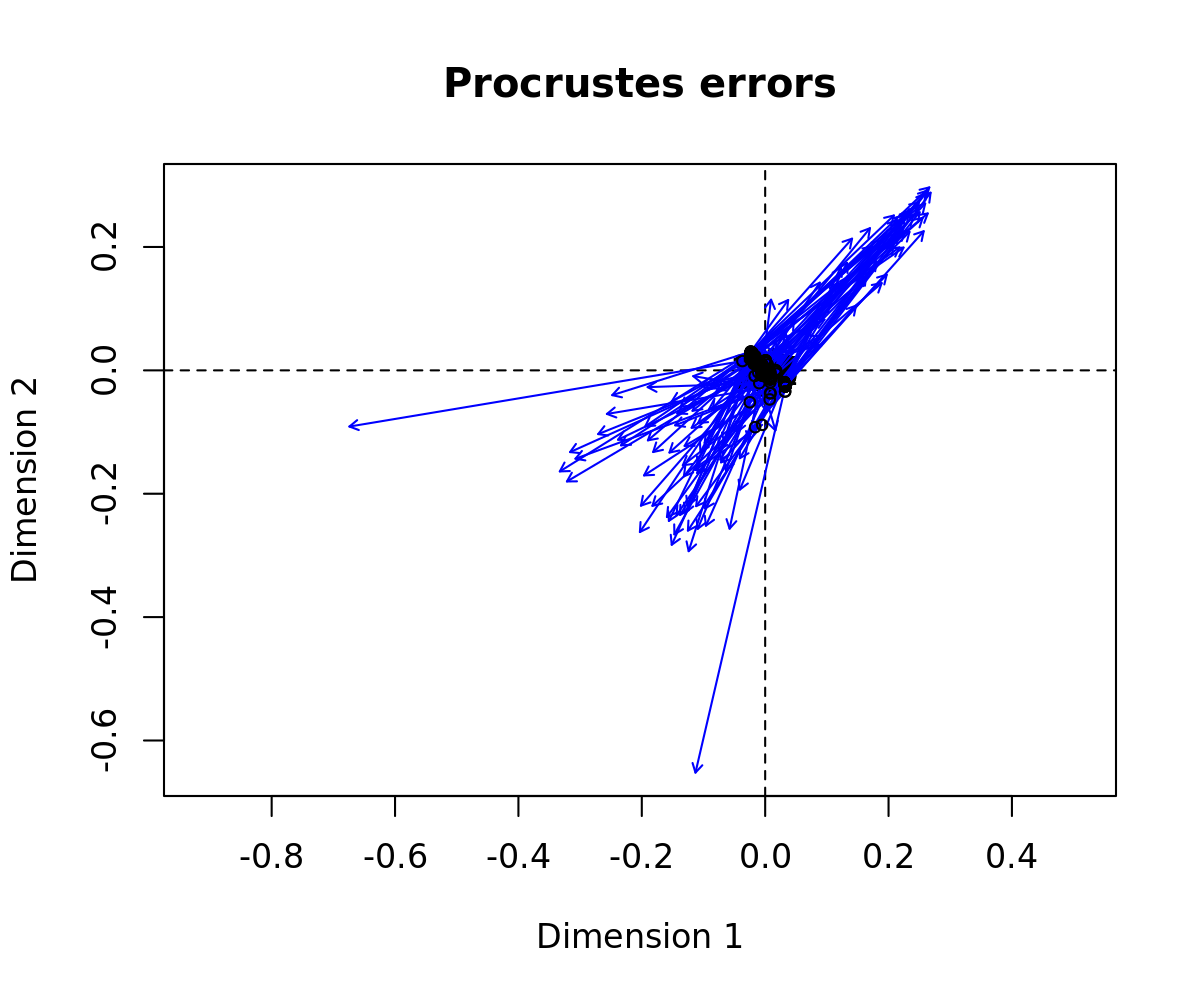

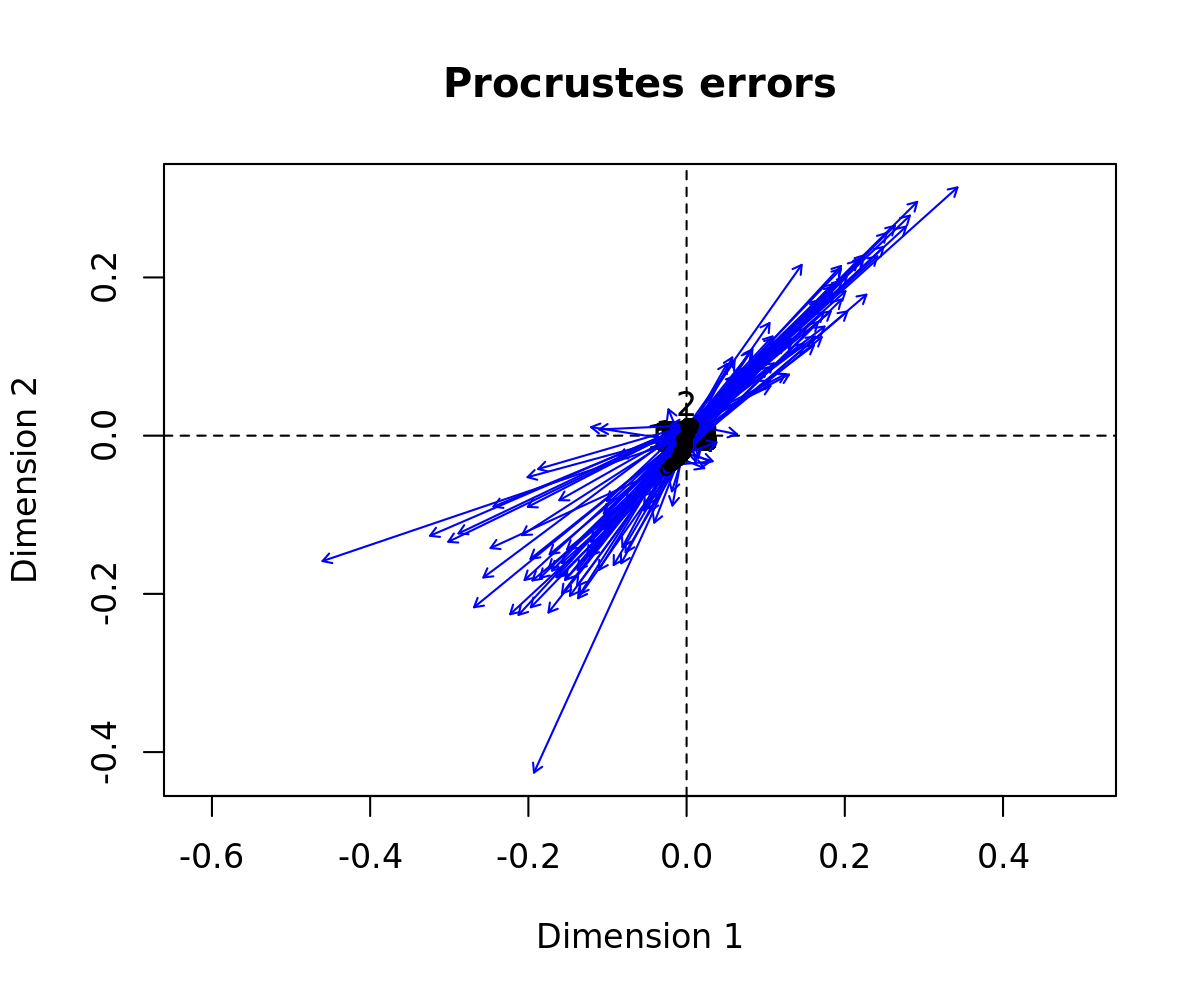

In [15]:
p.dims(6,5)
x = proc_res1 %>% lapply(plot)

In [16]:
# procrustes residuals
resids = proc_res1 %>% lapply(function(x) summary(x)$resid) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    mutate(sample = rownames(.))
resids

bray_curtis,jaccard,unweighted_unifrac,weighted_unifrac,sample
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2.060686,1.418990,1.414591,1.505853,X101_Horse
2.299736,1.563035,1.662483,1.452631,X102_Kulan
⋮,⋮,⋮,⋮,⋮
2.639040,1.888049,1.775283,1.4996995,F80_Red_Deer
1.813738,1.395907,1.334495,0.8842308,F90_Domestic_Dog


In [17]:
# formatting
resids = resids %>%
    gather(measure, value, -sample) %>%
    inner_join(meta, c('sample'='SampleID')) %>%
    mutate(measure = case_when(measure == 'bray_curtis' ~ 'Bray-Curtis',
                               measure == 'jaccard' ~ 'Jaccard',
                               measure == 'unweighted_unifrac' ~ 'Unweighted UniFrac',
                               measure == 'weighted_unifrac' ~ 'Weighted UniFrac'))
resids

sample,measure,value,class,order,family,genus,scientific_name,diet,habitat,sample_type
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
X101_Horse,Bray-Curtis,2.060686,Mammalia,Perissodactyla,Equidae,Equus,Equus_caballus,herbivore,terrestrial habitat,feces
X102_Kulan,Bray-Curtis,2.299736,Mammalia,Perissodactyla,Equidae,Equus,Equus_hemionus,herbivore,terrestrial habitat,feces
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
F80_Red_Deer,Weighted UniFrac,1.4996995,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,terrestrial habitat,feces
F90_Domestic_Dog,Weighted UniFrac,0.8842308,Mammalia,Carnivora,Canidae,Canis,Canis_lupus,carnivore,terrestrial habitat,feces


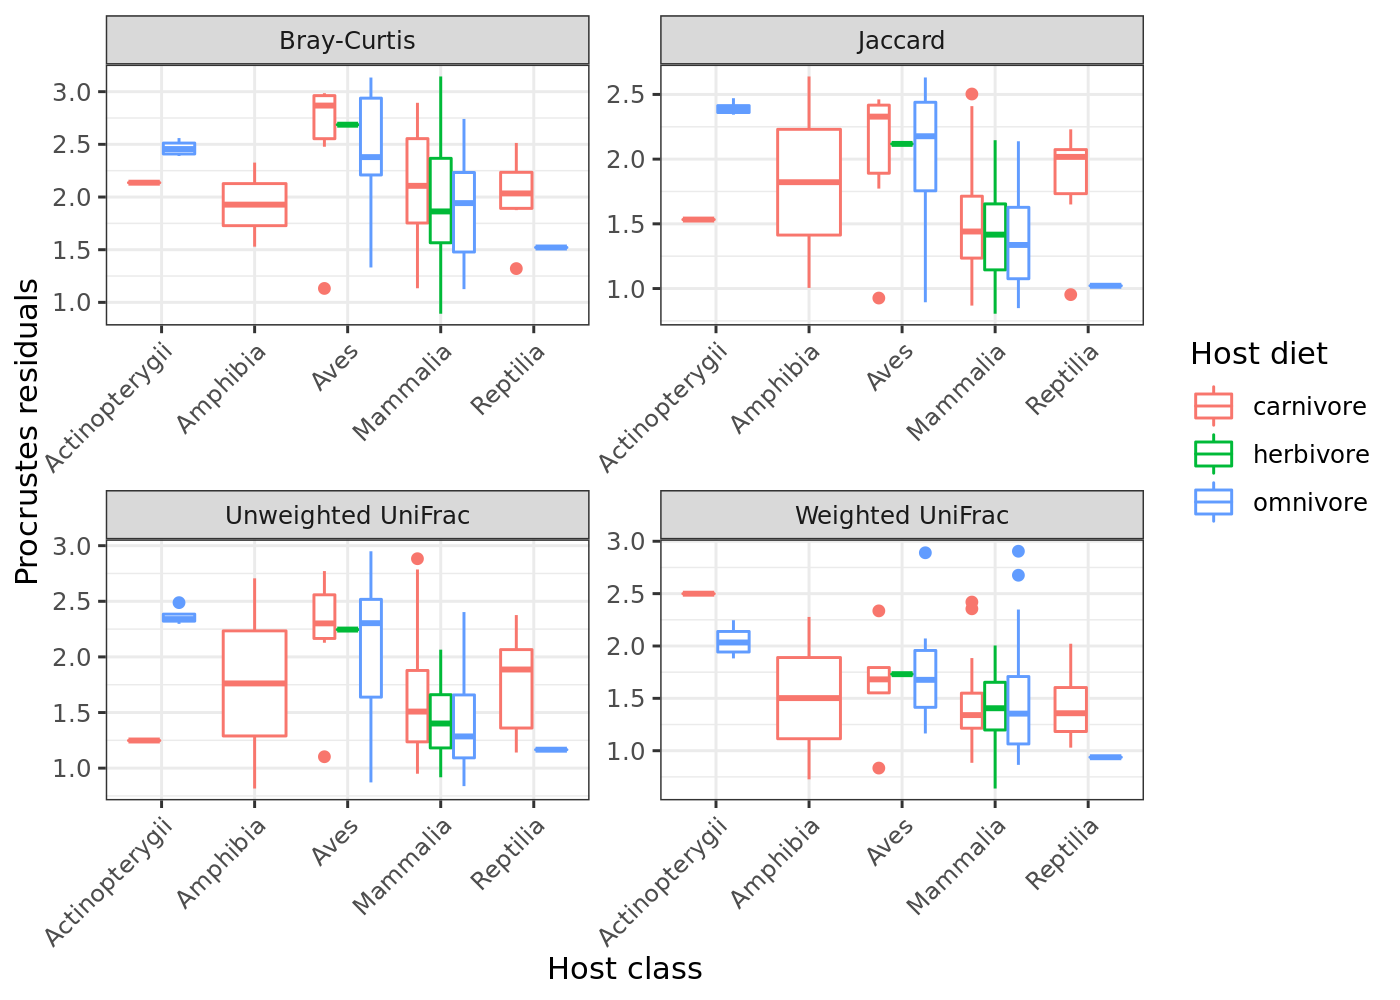

In [18]:
# plotting
p = resids %>%
    ggplot(aes(class, value, color=diet)) +
    geom_boxplot() +
    scale_color_discrete('Host diet') +
    labs(x='Host class', y='Procrustes residuals') +
    facet_wrap(~ measure, scales='free') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(7,5)
plot(p)

# sessionInfo

In [19]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-eco/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] LeyLabRMisc_0.1.6 doParallel_1.0.15 iterators_1.0.12  foreach_1.4.7    
 [5] vegan_2.5-6       lattice_0.20-38   permute_0.9-5     ape_5.3          
 [9] phyloseq_1.30.0   ggplot2_3.2.1     tidyr_1.0.0       dplyr_0.8.5      

loaded via a namespace (and not a